## Test the data for ap_pm

### Import data from csv and convert it to pm4py log. 

pm4py uses standardized column names to represent the *case identifier*, the *activity name* and the timstamp.
These are, respectively, ```case:concept:name```, ```concept:name``` and ```time:timestamp```.
Hence, to make pm4py work with the provided csv file, we need to rename the ```case_id```, ```activity``` and ```timestamp``` columns.

In [373]:
import numpy as np
import pandas as pd
import os 
import pm4py
import matplotlib.pyplot as plt
import networkx as nx


from pm4py.objects.dfg.retrieval.log import native
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.algo.filtering.log.attributes import attributes_filter as log_attributes_filter
from pm4py.statistics.traces.generic.log import case_statistics


#Default path for data for notebooks
PATH = os.path.join(  "data")

Get data for further analysis. The data is read from csv and exported to xes.

In [374]:
def get_data(path=PATH, sep=';' ,file_csv="p2p_simple.csv", file_xes="p2p_simple.xes", write=False):
    path_csv = os.path.join( path, file_csv)
    path_xes = os.path.join( path, file_xes)
    df = pd.read_csv(path_csv, sep=sep)
    log_csv = pm4py.format_dataframe(df, case_id='case_id',activity_key='activity',
                             timestamp_key='timestamp')
    if write:
        pm4py.write_xes(log_csv, path_xes)
    return pm4py.read_xes(path_xes)  

In [375]:
def get_time(input='sec',output='day', num=0):
    if input == 'sec':
        if output == 'day':
            return num/86400
        else:
            return num
    else:
        return num


xes log stores data as cases , df stores all events

In [376]:
#default file is p2p_simple.csv
log = get_data(file_csv='p2p_simple.csv', write=True)
print('start activities: {}'.format(pm4py.get_start_activities(log))) #get start activities
print('end activities: {}'.format(pm4py.get_end_activities(log))) #get end activities
print('case duration: {}'.format(pm4py.get_all_case_durations(log))) #get case duration
print('total number of events: {}'.format(sum(len(case) for case in log))) # total number of events
print('total number of traces: {}'.format(len(log)))#total number of traces
print('average trace size: {}'.format((sum(len(case) for case in log))/ (len(log)))) #average trace length
print('average trace size: {}'.format(len([(event["concept:name"]) for case in log for event in case]) / len(log))) #average trace size



parsing log, completed traces :: 100%|██████████| 2/2 [00:00<00:00, 1490.25it/s]

start activities: {'Create Purchase Request': 1, 'Create Purchase Order': 1}
end activities: {'Pay Invoice': 1, 'Create Goods Receipt': 1}
case duration: [37217520.0, 37464240.0]
total number of events: 10
total number of traces: 2
average trace size: 5.0
average trace size: 5.0


## Statistics 

pm4py statistics modules offer a lot of different methods for statistical analysis of logs

### Variants

In [377]:
import pm4py.statistics.variants.log.get as stats_var

print('number of variants: {}'.format(len(pm4py.get_variants_as_tuples(log))))
variants = stats_var.get_variants(log)
print('variants sorted by count: {}'.format(stats_var.get_variants_sorted_by_count(variants)))
print('KEYS:')
for key,value in variants.items():
    print(key) #values are the data for each case


number of variants: 2
variants sorted by count: [[('Create Purchase Request', 'Create Purchase Order', 'Create Invoice', 'Create Goods Receipt', 'Pay Invoice'), 1], [('Create Purchase Order', 'Create Invoice', 'Create Goods Receipt', 'Pay Invoice', 'Create Goods Receipt'), 1]]
KEYS:
('Create Purchase Request', 'Create Purchase Order', 'Create Invoice', 'Create Goods Receipt', 'Pay Invoice')
('Create Purchase Order', 'Create Invoice', 'Create Goods Receipt', 'Pay Invoice', 'Create Goods Receipt')


### Case Statistics

In [378]:
import pm4py.statistics.traces.generic.log.case_statistics as stats_cases
import pm4py.statistics.sojourn_time.log.get as stats_sojourn

print('variants with statistics: {}'.format(stats_cases.get_variant_statistics(log)))
cases_desc = stats_cases.get_cases_description(log)
print('Cases with durations:')
for key, value in cases_desc.items():
    print(key,'->', round(get_time(num=value['caseDuration'])), 'days')
#print('CASES DESCRIPTION: {}'.format(stats_cases.get_cases_description(log)[0]))
print('Events List FOR CASE 1 (only first activity in the list): {}'.format(stats_cases.get_events(log, case_id='1')[0]['activity']))
print('Median Duration: {}'.format(round(get_time(num=stats_cases.get_median_case_duration(log)))), 'days')
#https://en.wikipedia.org/wiki/Kernel_density_estimation
#print('KDE Duration: {}'.format(stats_cases.get_kde_caseduration_json(log)))
#events in p2p_simple log do not have duration(sojourn) otherwise there should be start_timestamp for each activity
#print(stats_sojourn.apply(log))


variants with statistics: [{'variant': ('Create Purchase Request', 'Create Purchase Order', 'Create Invoice', 'Create Goods Receipt', 'Pay Invoice'), 'count': 1}, {'variant': ('Create Purchase Order', 'Create Invoice', 'Create Goods Receipt', 'Pay Invoice', 'Create Goods Receipt'), 'count': 1}]
Cases with durations:
1 -> 434 days
2 -> 431 days
Events List FOR CASE 1 (only first activity in the list): Create Purchase Request
Median Duration: 434 days


In [379]:
import pm4py.statistics.traces.generic.log.case_arrival as stats_casearr
import pm4py.stats as stats 

print('avg time between case begins:',round(get_time(num=stats_casearr.get_case_arrival_avg(log))), 'days')
print('avg time between case ends:', round(get_time(num=stats_casearr.get_case_dispersion_avg(log))),'days')
print(stats.get_event_attributes(log))
print('events -> count: ', stats.get_event_attribute_values(log=log, attribute='activity'))
print('costs -> count: ', stats.get_event_attribute_values(log=log, attribute='costs'))
print('org:resource -> count: ', stats.get_event_attribute_values(log=log, attribute='org:resource'))

print('VARIANTS')
variants = stats.get_variants_as_tuples(log)
for key,value in variants.items():
    print(key)
print('REWORK for partial log')
print(stats.get_rework_cases_per_activity(log_partial))
print('Position summary for create invoice')
print(stats.get_activity_position_summary(log_partial, 'Create Invoice'))


avg time between case begins: 86 days
avg time between case ends: 83 days
['@@index', 'concept:name', 'activity', 'org:resource', 'timestamp', 'time:timestamp', 'case_id', 'costs']
events -> count:  {'Create Purchase Request': 1, 'Create Purchase Order': 2, 'Create Invoice': 2, 'Create Goods Receipt': 3, 'Pay Invoice': 2}
costs -> count:  {50: 1, 400: 2, 100: 2, 200: 5}
org:resource -> count:  {'Matthias': 1, 'Stephen': 3, 'Eilen': 2, 'Sarah': 1, 'Lea': 2, 'Majorie': 1}
VARIANTS
('Create Purchase Request', 'Create Purchase Order', 'Create Invoice', 'Create Goods Receipt', 'Pay Invoice')
('Create Purchase Order', 'Create Invoice', 'Create Goods Receipt', 'Pay Invoice', 'Create Goods Receipt')
REWORK for partial log
{'Create Purchase Order': 1, 'Create Invoice': 1, 'Create Goods Receipt': 1}
Position summary for create invoice
{2: 3, 1: 6, 3: 1}


## Process Discovery

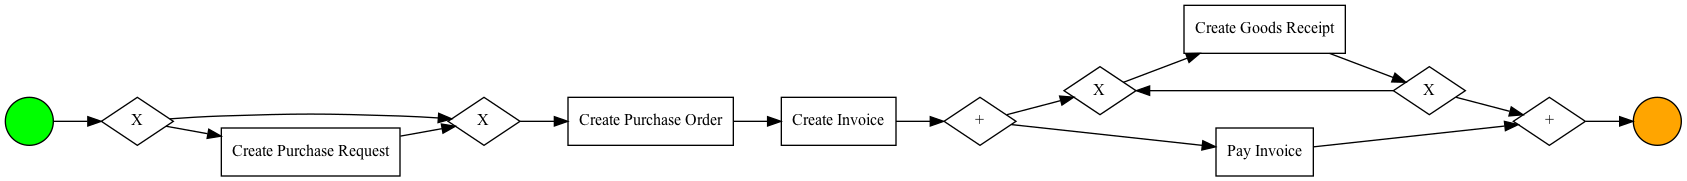

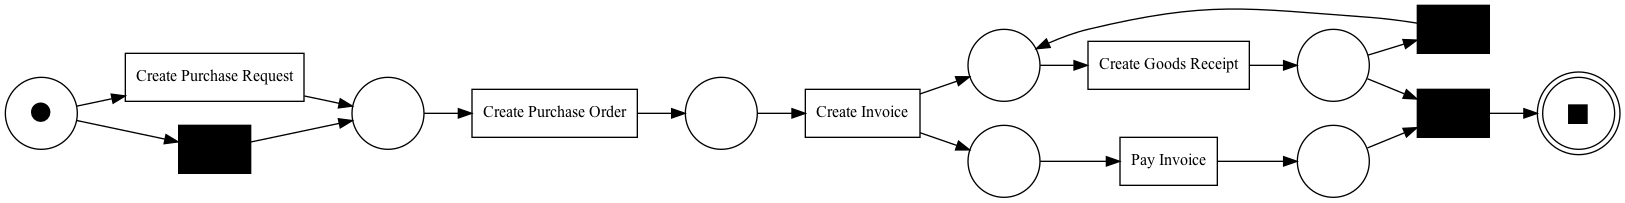

In [380]:
bpmn_model = pm4py.discover_bpmn_inductive(log)
pm4py.view_bpmn(bpmn_model)
net, im, fm = pm4py.discover_petri_net_inductive(log)
pm4py.view_petri_net(net, im, fm)

## Alignments

In [381]:
#TODO 


# LP Data from log

### Edges

### Nodes
node(0).
node(1).
node(2).
node(3).
node(4).

labelname(1,"DRIVE").
labelname(2,"LOAD").
labelname(3,"UNLOAD").

In [473]:
# Returns the names of all events in the log
def get_event_names(log):
    events = log_attributes_filter.get_attribute_values(log, "concept:name")
    event_list = sorted([*events])
    event_dict = {b: a for a,b in enumerate(event_list)}
    return event_dict

def get_event_num(log=log, name=''):
    events_dict = get_event_names(log)
    return dict((x, y) for x, y in events_dict.items())[name]

def get_event_name(log=log, number=0):
    events_dict = get_event_names(log)
    return dict((y, x) for x, y in events_dict.items())[number]

def create_adjacency_matrix(log):
    events = get_event_names(log)
    edges = [list(i) for i in [*(native(log))]]
    for edge in range(len(edges)):
        for node in range(len(edges[edge])):
            edges[edge][node] = events[edges[edge][node]]
            
    adjac_matrix = np.zeros(shape=(len(get_event_names(log)),len(get_event_names(log))))
    
    for (i,j) in edges:
        adjac_matrix[i][j] += 1

    return np.asarray(adjac_matrix)


#print(get_event_names(log))
adj_matrix = create_adjacency_matrix(log)
#print('Number for Create Invoice:',get_event_num(log, 'Create Invoice'))
#print('Key for Event 4:',get_event_name(log, 4))

print('NODES:')
nodes_names = list(get_event_names(log).keys())
nodes = list(get_event_names(log).values())
print(nodes)

print('EDGES')
edges_names = []
edges = []
for x,y in np.ndenumerate(adj_matrix):
    if y == 1:
        edges_names.append(get_event_name(log,x[0])+ '->'+ get_event_name(log, x[1]))
        edges.append((x[0], x[1]))
        
print(edges)



NODES:
[0, 1, 2, 3, 4]
EDGES
[(0, 4), (1, 0), (2, 1), (3, 2), (4, 0)]


In [434]:
import csv 

def write_file_for_michal():
    pass
#TODO Michal what do I need to pass to you 

EDGES:
[('Create Goods Receipt', 'Pay Invoice'), ('Pay Invoice', 'Create Goods Receipt'), ('Create Invoice', 'Create Goods Receipt'), ('Create Purchase Order', 'Create Invoice'), ('Create Purchase Request', 'Create Purchase Order')]
ITEMS
(('Create Goods Receipt', 'Pay Invoice'), {})
(('Pay Invoice', 'Create Goods Receipt'), {})
(('Create Invoice', 'Create Goods Receipt'), {})
(('Create Purchase Order', 'Create Invoice'), {})
(('Create Purchase Request', 'Create Purchase Order'), {})
NODES:
['Create Goods Receipt', 'Pay Invoice', 'Create Invoice', 'Create Purchase Order', 'Create Purchase Request']
['Create Goods Receipt', 'Pay Invoice', 'Create Invoice', 'Create Purchase Order', 'Create Purchase Request']


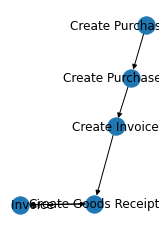

In [461]:

# Create directed graph
def create_directed_graph(log):
    DG = nx.DiGraph()
    matrix = create_adjacency_matrix(log)
    number_for_event = get_event_names(log)
    event_for_number = dict((y, x) for x, y in number_for_event.items())
    
    for row in range(len(matrix)):
        for event in range(len(matrix[row])):
                if matrix[row][event] > 0:
                    DG.add_edge(event_for_number[row], event_for_number[event])
                    DG.add_node(event_for_number[row])
                    
    return DG

def draw_graph(log, path=PATH, file='path_p2p_simple.png'):
    path_path = os.path.join( path, file)
    G = create_directed_graph(log)
    print('EDGES:')
    print(list(G.edges)) 
    edges = G.edges
    print('ITEMS')
    for item in G.edges.items():
        print(item)
    print('NODES:')
    print(list(G.nodes))
    subax1 = plt.subplot(121)
    edges_with_labels = { x: (x,y) for (x,y) in G.edges}
    print([key for key in edges_with_labels])
    #nx.draw_networkx_edge_labels(G, edge_labels=edges, pos=nx.spring_layout(G))
    #nx.draw_networkx_edges(G,edgelist=edges, pos=nx.spring_layout(G))
    nx.draw(G, with_labels = True)
    plt.savefig(path_path)
    plt.show()

def testing(log):
    G = create_directed_graph(log)
    print('Edges:')
    print(list(G.edges))
    print('Edges with labels')
    edges_with_labels = { x: (x,y) for (x,y) in G.edges}

draw_graph(log)

